# Building A Spotify Recommender

## Part 1: Data Preprocessing

In [174]:
import os
import re
import pandas as pd
import numpy as np
import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from secrets import SPOTIFY_HISTORY_DB

# Feature Engineering
from imblearn.over_sampling import SMOTE

# Sklearn - ML
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score

# Models
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

## Import Data

First we setup the connection to the SQL DB which contains 3 tables:
- **streaming_history**: each song listened to starting 02-01-2021
- **genres**: each of the artists from streaming_history, tagged with their corresponding genre
- **song_features**: each track from streaming_history, with details at the song level 
    - details include corresponding track values (liveness, tempo, valence etc.)

In [42]:
conn = sqlite3.connect(SPOTIFY_HISTORY_DB)

df_sh = pd.read_sql_query("SELECT * FROM streaming_history", conn)
df_genres = pd.read_sql_query("SELECT * FROM genres", conn)
df_features = pd.read_sql_query("SELECT * FROM song_features", conn)

In [43]:
df_sh.tail(1)

,spotify_id,uri,song_name,artist_name,played_at,duration_ms,date,ETL_DTTM,artist_uri
5199,0XlYnwY4PIabf1h6JI8fEm,spotify:track:0XlYnwY4PIabf1h6JI8fEm,D.A.D.A. (ASOT 1038),Armin van Buuren,2021-10-24 13:02:01.063000,88500,2021-10-24,"2021-10-25, 18:34:45",0SfsnGyD8FpIN4U4WCkBZ5


In [44]:
df_genres.head(1)

,spotify_url,total_followers,genres,artist_id,artist_name,popularity,uri,ETL_DTTM
0,https://open.spotify.com/artist/3SFVIUlipGj3Rp...,48610,"['bass trap', 'traprun']",3SFVIUlipGj3RpWCKe9s73,Lox Chatterbox,58,spotify:artist:3SFVIUlipGj3RpWCKe9s73,"2021-02-14, 09:25:59"


In [45]:
df_features.head(1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,ETL_DTTM
0,0.754,0.763,1,-6.57,1,0.295,0.32,0.0,0.143,0.704,159.963,audio_features,5ZcmLAogrj4HF8Odrz9XA2,spotify:track:5ZcmLAogrj4HF8Odrz9XA2,https://api.spotify.com/v1/tracks/5ZcmLAogrj4H...,https://api.spotify.com/v1/audio-analysis/5Zcm...,265693,3,"2021-02-04, 23:13:23"


The final query merges the data from the 3 tables into one master table, removing any potential duplicate records. If the same song was played over multiple days, there would be many.

In [46]:
merged_query = """
SELECT DISTINCT sh.spotify_id
    ,sh.uri
    ,sh.song_name
    ,sh.artist_name
    ,sh.artist_uri
    ,sh.played_at
    ,sh.date
    ,ETL_DTTM
    ,g.genres
    ,g.popularity
    ,sf.*
FROM streaming_history sh 
LEFT JOIN (SELECT DISTINCT *
    FROM (SELECT DISTINCT artist_id 
                ,artist_name
                ,genres
                ,popularity
                ,row_number() over (partition by artist_id order by artist_id, ETL_DTTM) as dup
            FROM genres)
    WHERE dup = 1) g
ON sh.artist_uri = g.artist_id
LEFT JOIN (SELECT DISTINCT id -- spotify track id
    ,danceability
    ,energy
    ,"key"
    ,loudness
    ,mode
    ,speechiness
    ,acousticness
    ,instrumentalness
    ,liveness
    ,valence
    ,tempo
    ,duration_ms
    ,time_signature
FROM song_features) sf
ON sh.spotify_id = sf.id
order by played_at
"""

df_spotify = pd.read_sql_query(merged_query, conn)

In [47]:
df_spotify.tail()

,spotify_id,uri,song_name,artist_name,artist_uri,played_at,date,ETL_DTTM,genres,popularity,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
5195,2h9otdWcqvn5D52cgS32fz,spotify:track:2h9otdWcqvn5D52cgS32fz,Échalo Pa' Ca,Sofía Reyes,0haZhu4fFKt0Ag94kZDiz2,2021-10-24 18:52:38.787000,2021-10-24,"2021-10-25, 18:34:45","['dance pop', 'latin', 'latin pop', 'mexican p...",71.0,...,-5.494,1.0,0.0857,0.18500,0.174000,0.293,0.584,100.015,222912.0,4.0
5196,7CxiUtNxJR6unRJRDc05St,spotify:track:7CxiUtNxJR6unRJRDc05St,Dum Dum,Kideko,0ZwQMCRqfyh1OGQkBh9Cnj,2021-10-24 19:02:22.101000,2021-10-24,"2021-10-25, 18:34:45","['deep groove house', 'disco house', 'edm', 'h...",53.0,...,-7.490,0.0,0.0762,0.00175,0.000018,0.428,0.768,122.506,208155.0,4.0
5197,4gRfV8ZoExS64ipJ5cZxip,spotify:track:4gRfV8ZoExS64ipJ5cZxip,Top of the League,Country Dons,76IdLCK81jcB44BTCgR7Vx,2021-10-24 19:13:13.650000,2021-10-24,"2021-10-25, 18:34:45","['uk drill', 'uk hip hop']",52.0,...,-9.654,1.0,0.2260,0.01960,0.000198,0.297,0.292,177.974,217079.0,4.0
5198,4L6rTjwwoqfOCn42JCAzDf,spotify:track:4L6rTjwwoqfOCn42JCAzDf,Have U Seen (feat. AJ Tracey),MISOGI,778Snztf3N5DXp0kHGFl3g,2021-10-24 19:16:57.930000,2021-10-24,"2021-10-25, 18:34:45","['emo rap', 'glitchcore', 'vapor twitch', 'wave']",51.0,...,-4.581,1.0,0.0502,0.03360,0.000141,0.114,0.172,129.978,223692.0,4.0
5199,1UQTXNXSJNqjqe79wGRlGm,spotify:track:1UQTXNXSJNqjqe79wGRlGm,Everyday,Guvna B,3XgNFNKLstByGKqplDht0H,2021-10-24 19:19:59.293000,2021-10-24,"2021-10-25, 18:34:45","['christian hip hop', 'christian trap', 'uk ch...",48.0,...,-6.484,0.0,0.2520,0.24600,0.000575,0.126,0.612,135.067,203639.0,4.0


## EDA & Data Cleaning

A brief data overview extracted directly from Kaggle:

#### Spotify Data Dictionary:
The Spotify API call returns basic track info such as id, song name, artist and genre, but also more detailed values such as:

##### Numerical columns:

- **acousticness**: The relative metric of the track being acoustic, (Ranges from 0 to 1)
- **danceability**: The relative measurement of the track being danceable, (Ranges from 0 to 1)
- **energy**: The energy of the track, (Ranges from 0 to 1)
- **duration_ms**: The length of the track in milliseconds (ms), (Integer typically ranging from 200k to 300k)
- **instrumentalness**: The relative ratio of the track being instrumental, (Ranges from 0 to 1)
- **valence**: The positiveness of the track, (Ranges from 0 to 1)
- **popularity**: The popularity of the song lately, default country = US, (Ranges from 0 to 100)
- **tempo**:The tempo of the track in Beat Per Minute (BPM), (Float typically ranging from 50 to 150)
- **liveness**: The relative duration of the track sounding as a live performance, (Ranges from 0 to 1)
- **loudness**: Relative loudness of the track in decibel (dB), (Float typically ranging from -60 to 0)
- **speechiness**: The relative length of the track containing any kind of human voice, (Ranges from 0 to 1)
- **year**: The release year of track, (Ranges from 1921 to 2020)
- **id**: The primary identifier for the track, generated by Spotify

##### Categorical columns:

- **key**: The primary key of the track encoded as integers in between 0 and 11 (starting on C as 0, C# as 1 and so on…)
- **artists**: The list of artists credited for production of the track
- **release_date**: Date of release mostly in yyyy-mm-dd format, however precision of date may vary
- **name**: The title of the track
- **mode**: The binary value representing whether the track starts with a major (1) chord progression or a minor (0)
- **explicit**: The binary value whether the track contains explicit content or not, (0 = No explicit content, 1 = Explicit content)

In [48]:
print("Total number of songs streamed: ", len(df_spotify))
print("Number of unique songs: ", len(df_spotify.spotify_id.unique()))
print("Number of unique artists: ", len(df_spotify.artist_uri.unique()))

Total number of songs streamed:  5200
Number of unique songs:  1330
Number of unique artists:  455


In [49]:
df_spotify.dtypes

spotify_id           object
uri                  object
song_name            object
artist_name          object
artist_uri           object
played_at            object
date                 object
ETL_DTTM             object
genres               object
popularity          float64
id                   object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms         float64
time_signature      float64
dtype: object

In [50]:
df_spotify['genres'].values[4362]

"['belgian dance', 'belgian edm', 'big room', 'dance pop', 'edm', 'electro house', 'pop dance', 'progressive electro house', 'tropical house']"

We see that the genres column appears to be a list at first glance, but is not actually in a list format:

In [51]:
df_spotify['genres'].values[4362][0]

'['

To fix this, a Regular Expression (regex) statement will be used to return a list for each genre. For records without a genre, an empty list will be input.

In [52]:
df_spotify['genres'] = df_spotify['genres'].fillna('[]').apply(lambda x: [re.sub(' ', '_', i) for i in re.findall(r"'([^']*)'", x)])

In [53]:
df_spotify['genres'].values[4362][0]

'belgian_dance'

In [54]:
# create list of columns which are numeric
num = df_spotify.select_dtypes(include=np.number)
column_list = num.columns.to_list()

At this point I would like to visualize the distribution of the many data points available. Some knowledge of key attributes may help with model building later on. 

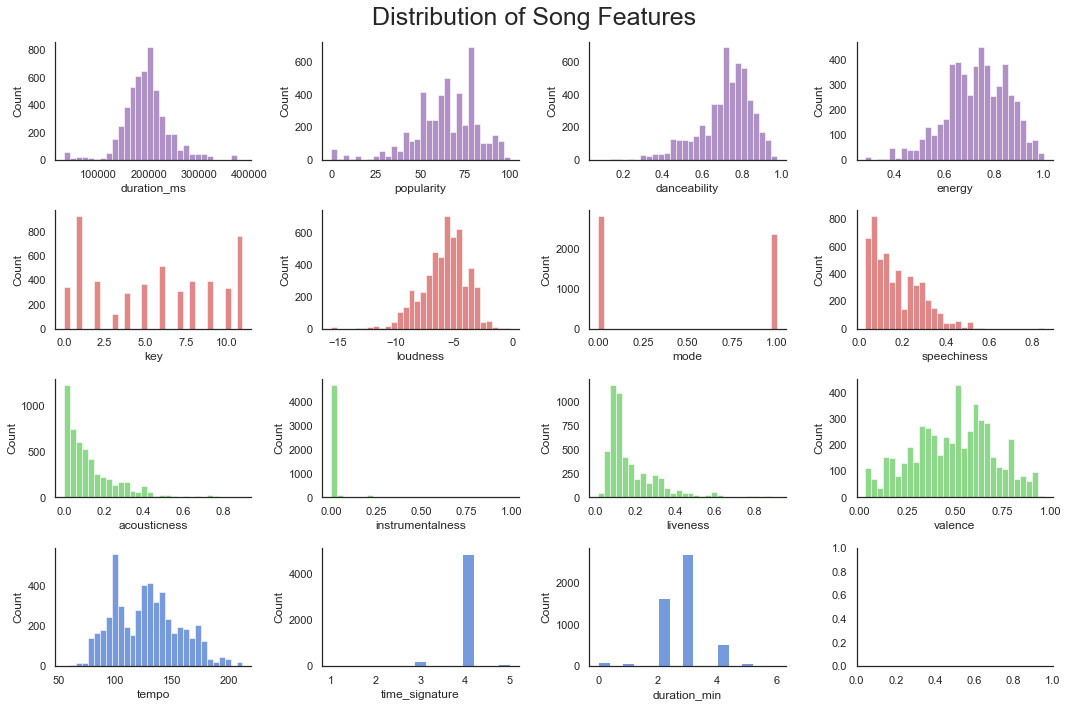

In [55]:
sns.set(style="white", palette="muted", color_codes=True)

fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharex=False)
sns.despine(right=True)

sns.histplot(df_spotify['duration_ms'], kde=False, bins=30, ax=axes[0, 0], color="m")
sns.histplot(df_spotify['popularity'], kde=False, bins=30, ax=axes[0, 1], color="m")
sns.histplot(df_spotify['danceability'], kde=False, bins=30, ax=axes[0, 2], color="m")
sns.histplot(df_spotify['energy'], kde=False, bins=30, ax=axes[0, 3], color="m")

sns.histplot(df_spotify['key'], kde=False, bins=30, ax=axes[1, 0], color="r")
sns.histplot(df_spotify['loudness'], kde=False, bins=30, ax=axes[1, 1], color="r")
sns.histplot(df_spotify['mode'], kde=False, bins=30, ax=axes[1, 2], color="r")
sns.histplot(df_spotify['speechiness'], kde=False, bins=30, ax=axes[1, 3], color="r")

sns.histplot(df_spotify['acousticness'], kde=False, bins=30, ax=axes[2, 0], color="g")
sns.histplot(df_spotify['instrumentalness'], kde=False, bins=30, ax=axes[2, 1], color="g")
sns.histplot(df_spotify['liveness'], kde=False, bins=30, ax=axes[2, 2], color="g")
sns.histplot(df_spotify['valence'], kde=False, bins=30, ax=axes[2, 3], color="g")

sns.histplot(df_spotify['tempo'], kde=False, bins=30, ax=axes[3, 0])
sns.histplot(df_spotify['time_signature'], kde=False, bins=15, ax=axes[3, 1])
sns.histplot(df_spotify['duration_ms'] // 60000, kde=False, bins=15, ax=axes[3, 2]).set_xlabel('duration_min')
#sns.histplot(df_spotify['valence'], kde=False, bins=30, ax=axes[3, 3])

plt.suptitle('Distribution of Song Features', fontsize=25)
plt.tight_layout()

<AxesSubplot:>

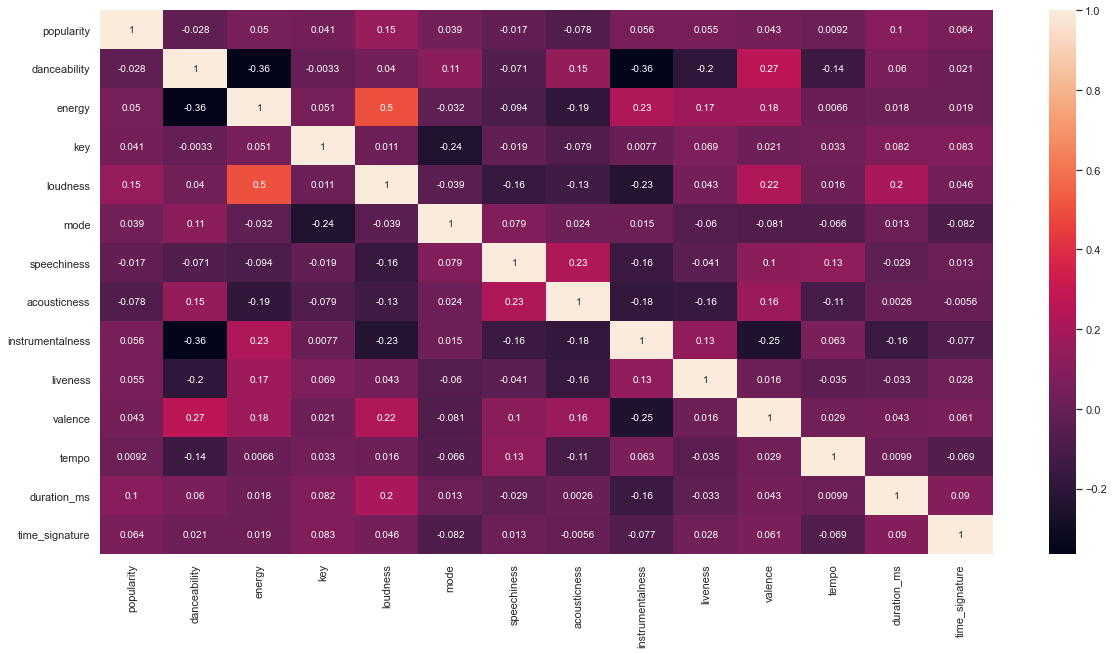

In [151]:
# Correlation between attributes
plt.figure(figsize = (20,10))
sns.heatmap(df_spotify.corr(), annot=True)

From the song features taken from my listening history, the following attributes have some notable correlations:
- loudness and energy: 0.52
- danceability and valence: 0.25
- acousticness and speechiness: 0.23

Below we can see that the majority of tracks were played less than 10 times (frequency). On this basis, I can consider a playback count of >10 times to be one of my more favourite songs.

Text(0.5, 1.0, 'Distribution of Song Playback Frequency')

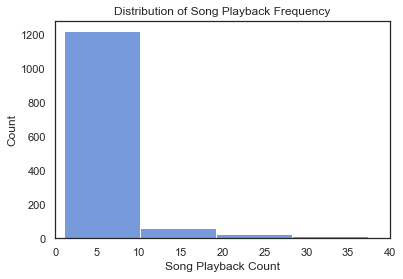

In [57]:
playback_count = df_spotify.groupby(['song_name', 'artist_name', 'spotify_id']).size().to_frame('count').sort_values(['count'], ascending=False).reset_index()

sns.histplot(playback_count['count'], bins=10).set(xlim=(0,40))
plt.xlabel('Song Playback Count')
plt.ylabel('Count')
plt.title('Distribution of Song Playback Frequency')

# ax = playback_count.plot(kind='hist', bins=9)
# ax.set_xlim(0,40)
# ax.set_title("Distribution of Playback Frequency")

In [58]:
df_fav = df_spotify.groupby(['song_name', 'artist_name', 'spotify_id']).size().to_frame('count').sort_values(['count'], ascending=False).reset_index()
df_fav = df_fav[df_fav['count'] >= 10]

In [59]:
pd.read_sql_query("""
SELECT DISTINCT spotify_id, song_name, artist_name, Count(*) AS playback_count, Sum(duration_ms/60000) as listen_time_min
FROM streaming_history
GROUP BY 1,2,3
HAVING playback_count >= 10
ORDER BY playback_count DESC
""", conn)

,spotify_id,song_name,artist_name,playback_count,listen_time_min
0,2oZagYx3ZyigFqguLrbon9,Puertosol Golden Coast,Vegas Jones,92,276
1,63ZHGDgE804BwJfCZkX1Vy,AMG,Sacky,85,255
2,4dVpf9jZjcORqGTLUaeYj9,Plain Jane,A$AP Ferg,59,118
3,3YXOKfDchF2QRNXXJpgmCx,"Shotta 2 (feat. Vale Pain, Baby Gang, Nko)",RM4E,52,104
4,1zsnUOfuMirWoprylSMuTZ,Gucci Ski Mask (feat. Guè Pequeno),Lazza,48,144
...,...,...,...,...,...
122,4FCjPKRLOiLrg1OTfwDnZN,Accion,"Franco ""El Gorilla""",10,30
123,4gAxLlI7QGIXzjmtg0RJNd,Muévelo,Wisin,10,30
124,6gBFPUFcJLzWGx4lenP6h2,goosebumps,Travis Scott,10,40
125,7ssFG94tZHpX9vbIFM0GVH,No Excuses,NF,10,30


In [60]:
pd.read_sql_query("""
SELECT avg(playback_count) as avg_playback_count, avg(listen_time) as avg_listen_time_min
    ,Sum(playback_count) as total_playback, Sum(listen_time) as total_listen_time_min
FROM (
SELECT DISTINCT spotify_id, song_name, artist_name, Count(*) AS playback_count, Sum(duration_ms/60000) as listen_time
FROM streaming_history
GROUP BY 1,2,3) S
""", conn)

,avg_playback_count,avg_listen_time_min,total_playback,total_listen_time_min
0,3.900975,10.764441,5200,14349


<AxesSubplot:>

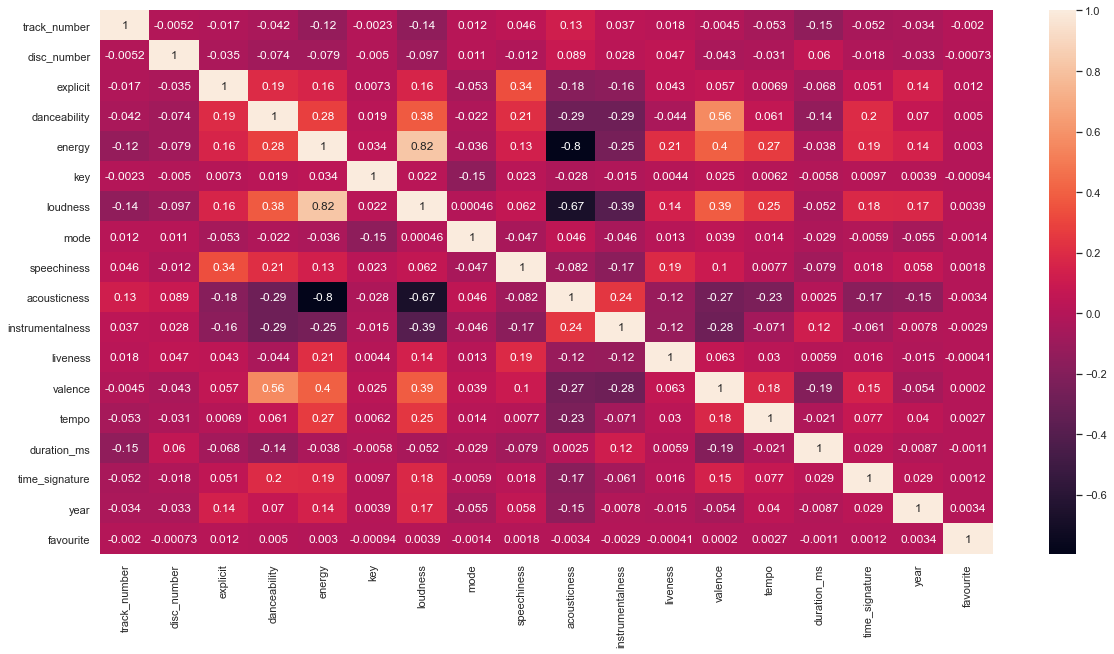

In [64]:
# Correlation between attributes
plt.figure(figsize = (20,10))
sns.heatmap(spotify_tracks_df.corr(), annot=True)

Load Spotify Features dataset with 232,725 tracks with 26 genres and approximately 10,000 tracks per genre. This may improve model performance (compared to other data sets) because I tend to listen to a wide range of genres.

https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db

In [65]:
# load features dataset
spotify_features = pd.read_csv("SpotifyFeatures.csv")

In [66]:
# tag songs which were my favourite
spotify_features["favourite"] = np.where(spotify_features.track_id.isin(df_fav.spotify_id),1,0)

#get the relative breakdown of favourite vs non
spotify_features.favourite.value_counts()

0    232670
1        55
Name: favourite, dtype: int64

<AxesSubplot:>

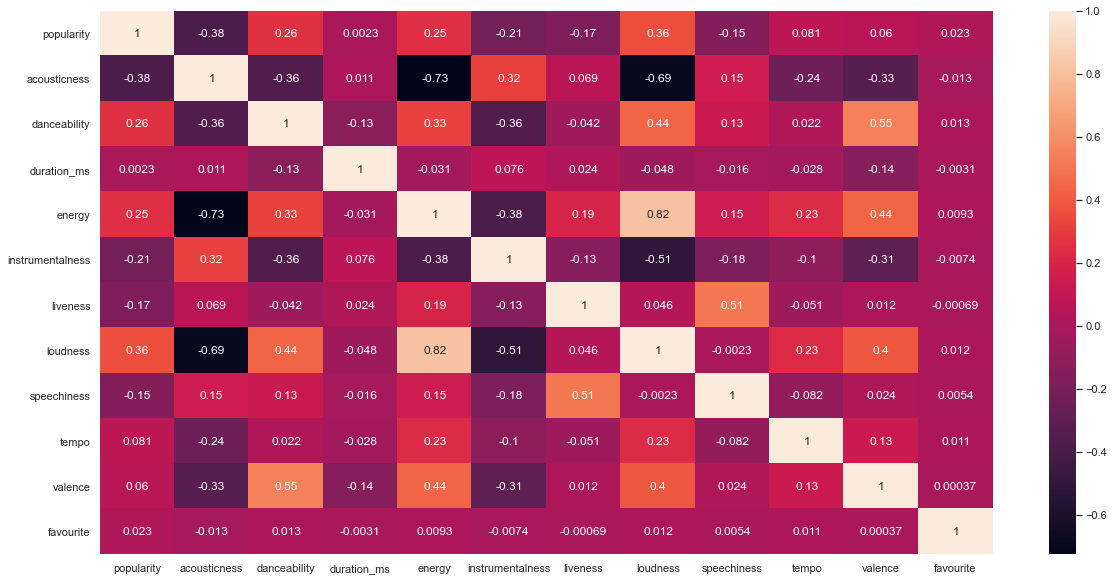

In [67]:
# Correlation between attributes
plt.figure(figsize = (20,10))
sns.heatmap(spotify_features.corr(), annot=True)

## Part 2: Feature Engineering

In [68]:
spotify_features[spotify_features['favourite'] == 1].head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,favourite
66608,Hip-Hop,Meek Mill,Going Bad (feat. Drake),2IRZnDFmlqMuOrYOLnZZyc,95,0.2590,0.889,180522,0.496,0.0000,E,0.252,-6.365,Minor,0.0905,86.003,4/4,0.544,1
66634,Hip-Hop,French Montana,No Stylist,04MLEeAMuV9IlHEsD8vF6A,88,0.0215,0.765,192172,0.704,0.0000,F,0.227,-4.589,Minor,0.1270,147.055,4/4,0.498,1
66680,Hip-Hop,A$AP Ferg,Plain Jane,4dVpf9jZjcORqGTLUaeYj9,81,0.0651,0.797,173600,0.844,0.0000,B,0.087,-5.482,Major,0.2750,170.142,4/4,0.520,1
66900,Hip-Hop,Meek Mill,Uptown Vibes (feat. Fabolous & Anuel AA),2tnlNVAhuQGgoFJxALVeXx,74,0.0459,0.655,190412,0.835,0.0000,C#,0.409,-3.451,Major,0.0590,91.035,4/4,0.165,1
67310,Hip-Hop,Future,Call the Coroner,1WlU4jsJ8AoTB96dgd8LJA,69,0.1460,0.853,131756,0.805,0.0515,B,0.204,-3.331,Minor,0.2020,134.550,4/4,0.879,1


### SMOTE (Synthetic Minority Oversampling Technique) for Balancing Classes

As we can see below, the ratio of favourite tracks to non-favourite tracks is heavily imbalanced, so would need to oversample the minority class to provide more balance. This will prevent the ML model from predicting most songs as the majority class (i.e. non-favourite)

In [69]:
spotify_features.favourite.value_counts()

0    232670
1        55
Name: favourite, dtype: int64

In [70]:
X = spotify_features.drop(columns=['genre', 'artist_name', 'track_name', 'track_id', 'key', 'mode', 'time_signature', 'favourite'])
y = spotify_features.favourite

oversample = SMOTE()

X, y = oversample.fit_resample(X,y)
X['favourite'] = y

X

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,favourite
0,0,0.611000,0.389000,99373,0.910000,0.0000,0.346000,-1.828000,0.052500,166.969000,0.814000,0
1,1,0.246000,0.590000,137373,0.737000,0.0000,0.151000,-5.559000,0.086800,174.003000,0.816000,0
2,3,0.952000,0.663000,170267,0.131000,0.0000,0.103000,-13.879000,0.036200,99.488000,0.368000,0
3,0,0.703000,0.240000,152427,0.326000,0.0000,0.098500,-12.178000,0.039500,171.758000,0.227000,0
4,4,0.950000,0.331000,82625,0.225000,0.1230,0.202000,-21.150000,0.045600,140.576000,0.390000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
465335,69,0.146000,0.853000,131756,0.805000,0.0515,0.204000,-3.331000,0.202000,134.550000,0.879000,1
465336,74,0.045900,0.655000,190412,0.835000,0.0000,0.409000,-3.451000,0.059000,91.035000,0.165000,1
465337,83,0.098424,0.812811,174789,0.784192,0.0000,0.115357,-5.633753,0.243292,155.681796,0.524125,1
465338,68,0.093300,0.813000,208027,0.453000,0.0000,0.140000,-6.941000,0.338000,161.997000,0.191000,1


<AxesSubplot:>

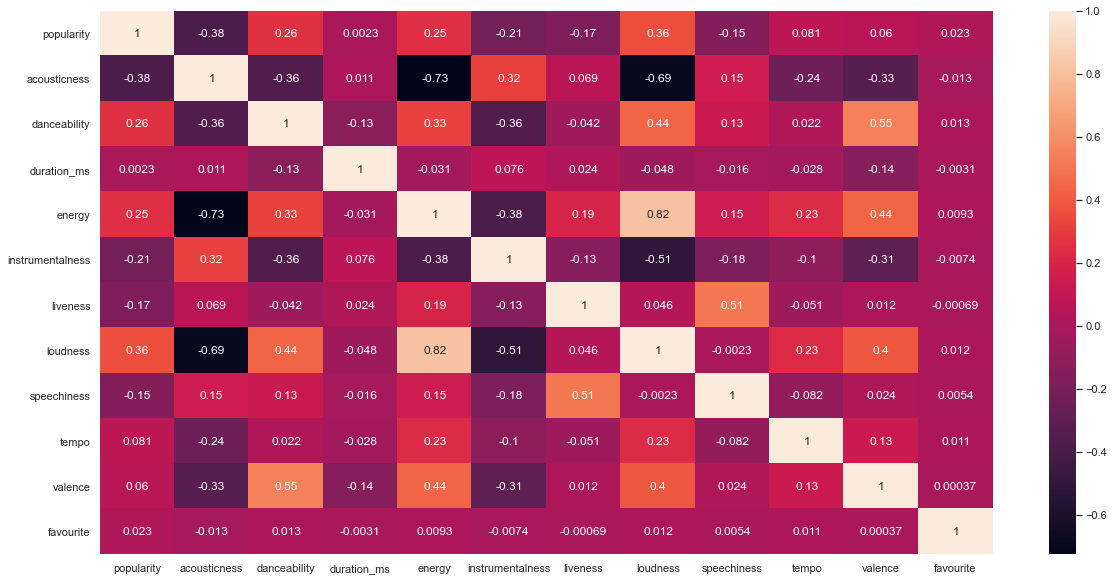

In [71]:
# Correlation between attributes
plt.figure(figsize = (20,10))
sns.heatmap(spotify_features.corr(), annot=True)

## Part 3: Model Building

In [72]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='favourite'), X.favourite, test_size = .30)

### Logistic Regression

In [73]:
%%time
# Logistic Regression
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
np.mean(lr_scores)

Wall time: 26.3 s


C:\Users\vijay\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8055253796111863

### Decision Tree

In [74]:
%%time
# Hyperparameter optimization for Decision Tree Classifier
parameters = {
    #'max_depth':[15,20,30],
    'max_depth':[10,15,30],
}
dtc = Pipeline([('CV', GridSearchCV(DecisionTreeClassifier(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

Wall time: 56.9 s


{'max_depth': 30}

In [75]:
pd.DataFrame(dtc.named_steps['CV'].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.219453,0.089939,0.015806,0.002150,10,{'max_depth': 10},0.984973,0.985571,0.984681,0.985325,0.984804,0.985071,0.000331,3
1,2.929793,0.214965,0.014798,0.000749,15,{'max_depth': 15},0.987889,0.988058,0.987413,0.988104,0.987674,0.987828,0.000256,2
2,5.093126,0.696910,0.018996,0.001776,30,{'max_depth': 30},0.997467,0.997652,0.997114,0.997237,0.997252,0.997344,0.000191,1


In [76]:
%%time
# Decision Tree
dt = DecisionTreeClassifier(max_depth=30)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

Wall time: 54 s


0.997478538381905

### Random Forest

In [77]:
%%time
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[6,12,15,20],
    'n_estimators':[20,30]
}
clf = Pipeline([('CV', GridSearchCV(RandomForestClassifier(), parameters, cv = 5))])
clf.fit(X_train, y_train)
clf.named_steps['CV'].best_params_

Wall time: 8min 20s


{'max_depth': 20, 'n_estimators': 20}

In [78]:
pd.DataFrame(clf.named_steps['CV'].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.799750,0.611308,0.110597,0.009083,6,20,"{'max_depth': 6, 'n_estimators': 20}",0.974596,0.976576,0.974642,0.974396,0.976023,0.975247,0.000881,8
1,8.896806,0.442456,0.147167,0.002292,6,30,"{'max_depth': 6, 'n_estimators': 30}",0.978848,0.978403,0.977682,0.978295,0.975931,0.977832,0.001021,7
2,9.268820,0.409217,0.121396,0.005039,12,20,"{'max_depth': 12, 'n_estimators': 20}",0.990652,0.989885,0.988948,0.991957,0.988073,0.989903,0.001345,6
3,13.805579,0.656644,0.171757,0.005172,12,30,"{'max_depth': 12, 'n_estimators': 30}",0.989455,0.990698,0.991358,0.990099,0.988871,0.990096,0.000879,5
4,10.218079,0.086721,0.122995,0.006753,15,20,"{'max_depth': 15, 'n_estimators': 20}",0.991220,0.992555,0.992218,0.993031,0.993215,0.992448,0.000707,3
5,15.611088,0.411535,0.176591,0.008446,15,30,"{'max_depth': 15, 'n_estimators': 30}",0.992294,0.991926,0.992141,0.991987,0.991005,0.991871,0.000451,4
6,12.350755,0.122355,0.139000,0.004050,20,20,"{'max_depth': 20, 'n_estimators': 20}",0.996853,0.996301,0.997206,0.995211,0.996024,0.996319,0.000691,1
7,18.464173,0.085019,0.200022,0.003188,20,30,"{'max_depth': 20, 'n_estimators': 30}",0.996638,0.995886,0.996331,0.996163,0.995103,0.996024,0.000521,2


In [79]:
%%time
# Cross-validation for RandomForestClassifier
rf = Pipeline([('rf', RandomForestClassifier(n_estimators = 20, max_depth = 30))])
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

Wall time: 3min 13s


0.9994719990183158

In [133]:
# Save model to file
filename = 'spotify_rf.sav'
pickle.dump(clf, open(filename, 'wb'))
print('Random Forest model saved to file.')

Random Forest model saved to file.


To recap, we can see below that the Random Forest yielded the highest F1 score for the song prediction problem.

In [157]:
print("Logistic Regression F1 Score: {}".format(np.mean(lr_scores)))
print("Decision Tree F1 Score: {}".format(np.mean(dt_scores)))
print("Random Forest F1 Score: {}".format(np.mean(rf_scores)))

Logistic Regression F1 Score: 0.8055253796111863
Decision Tree F1 Score: 0.997478538381905
Random Forest F1 Score: 0.9957399570416545


## Part 4: Make Predictions

In [165]:
# Load test data set
test_df = spotify_features.copy(deep=True)

In [166]:
# Load model
load_rf_model = pickle.load(open(filename, 'rb'))
print('Random Forest model loaded from file.')

Random Forest model loaded from file.


In [167]:
prediction = load_rf_model.predict(test_df.drop(columns=['track_name','track_id','favourite','genre','artist_name','key','time_signature','mode']))

In [168]:
pd.DataFrame(prediction).value_counts()

0    231191
1      1534
dtype: int64

In [169]:
test_df['prediction'] = prediction

In [170]:
#pd.set_option('display.max_rows', prediction_df.shape[0] + 1)
prediction_df = test_df[(test_df['prediction'] == 1) & (test_df['favourite'] == 0)].reset_index()
prediction_df.head()

,index,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,favourite,prediction
0,135,R&B,Mary J. Blige,Be Without You - Kendu Mix,2YegxR5As7BeQuVp2U6pek,65,0.0830,0.724,246333,0.689,...,D,0.304,-5.922,Minor,0.1350,146.496,4/4,0.693,0,1
1,148,R&B,TWENTY88,On The Way,2TAf6ITyhwc9Z3MYb4tSYl,61,0.0808,0.584,203227,0.687,...,C#,0.200,-7.176,Minor,0.3210,129.902,4/4,0.324,0,1
2,186,R&B,City Girls,Season (feat. Lil Baby),1VAIB64hpLeaoDKzaCLywU,61,0.0101,0.595,202943,0.695,...,G,0.157,-4.634,Major,0.3060,139.037,5/4,0.401,0,1
3,214,R&B,GoldLink,Got Friends,1PVza5KmhSJhz12OewWciE,67,0.1040,0.691,226963,0.750,...,A#,0.123,-3.934,Minor,0.3470,143.744,4/4,0.345,0,1
4,233,R&B,SZA,Prom,5yvhdo8FXbBsIllxv2Rr94,64,0.0658,0.805,196133,0.702,...,C#,0.123,-4.877,Major,0.0887,120.041,4/4,0.225,0,1


### Final Thoughts

On an anecdotal note, the model seems to be relatively accurate, as the top predictions are weighted into genres which I typically listen to (Rap, Hip-Hop, Dance). However there are a few genres which seem questionable such as Children's Music, Country and Folk. Perhaps the song features from thos particular songs match those from the training data. The only way to find out is to give the tracks a listen!

Update: It turns out Linkin Park is classified as Children's Music :P

In [173]:
prediction_df.genre.value_counts().to_frame().reset_index().rename(columns = {'index':'genre', 'genre':'count'})

,genre,count
0,Pop,387
1,Rap,353
2,Hip-Hop,315
3,Dance,140
4,R&B,94
5,Reggaeton,67
6,Indie,41
7,Children’s Music,26
8,Rock,19
9,Soul,15


In [176]:
# Save to csv file
from datetime import date
prediction_df.to_csv('{}_Spotify_Recommendation.csv'.format(date.today()))